Kaggle Dataset Diabetes, Hypertensionand Stroke Prediction:https://www.kaggle.com/datasets/prosperchuks/health-dataset/data

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)


In [75]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import os
from google.colab import files
from google.colab import drive
import pickle

In [76]:
'''
uploaded = files.upload("diabetes_data.csv")               # click “Choose Files” and select your CSV
uploaded = files.upload("suffled_diabetes_data.csv")
'''             # click “Choose Files” and select your CSV
data_path = "/content/drive/MyDrive/colab_checkpoints/diabetes_data.csv"
shuffled_data_path = "/content/drive/MyDrive/colab_checkpoints/shuffled_diabetes_data.csv"



_drive_mount_path = '/content/drive'
drive.mount(_drive_mount_path)

eval_checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints/model_evaluation_data'
os.makedirs(eval_checkpoint_dir, exist_ok=True)
checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints/overfitting_data'
os.makedirs(checkpoint_dir, exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import tensorflow as tf
# List physical devices to confirm GPU is available
print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Thu May  1 19:48:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |    2188MiB /  15360MiB |      0%      Default |
|                                         |              

Used to hopefully boost performance using the T4 GPU in google colab

In [78]:
# 0) (Optional) sanity-check that you have a T4
!nvidia-smi --query-gpu=name,driver_version,uuid --format=csv

# 1) Imports + XLA JIT
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)


name, driver_version, uuid
Tesla T4, 550.54.15, GPU-8f2b3450-5600-4da7-d10b-044b7004ee10
Compute dtype: float16
Variable dtype: float32


Used to shuffle the dataset so that the predictions are not unevely measured.

In [79]:
#Change these paths as needed
data_path = "/content/drive/MyDrive/colab_checkpoints/diabetes_data.csv"
shuffled_data_path =  "/content/drive/MyDrive/colab_checkpoints/shuffled_diabetes_data.csv"

In [80]:
# Load the dataset
df = pd.read_csv(data_path)

#Shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Save the shuffled dataframe to a new CSV file
df_shuffled.to_csv(shuffled_data_path, index=False)

# Phase 1

Dataset shape: (70692, 18)
    Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0  10.0  0.0       1.0        1.0  23.0     1.0                   0.0   
1  13.0  0.0       0.0        1.0  33.0     1.0                   0.0   
2   8.0  1.0       1.0        1.0  27.0     1.0                   0.0   
3   7.0  1.0       1.0        1.0  29.0     1.0                   0.0   
4   6.0  1.0       0.0        1.0  47.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      4.0       0.0   
1           0.0     1.0      1.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      2.0       0.0   
3           0.0     1.0      0.0                0.0      3.0       0.0   
4           1.0     1.0      1.0                0.0      4.0      30.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0       0.0       0.0     0.0     0.0  

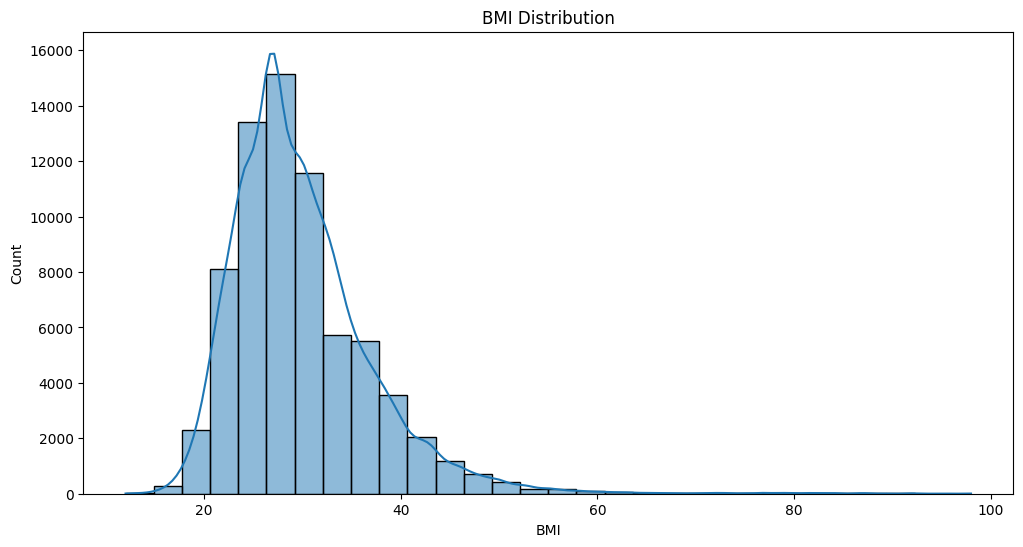

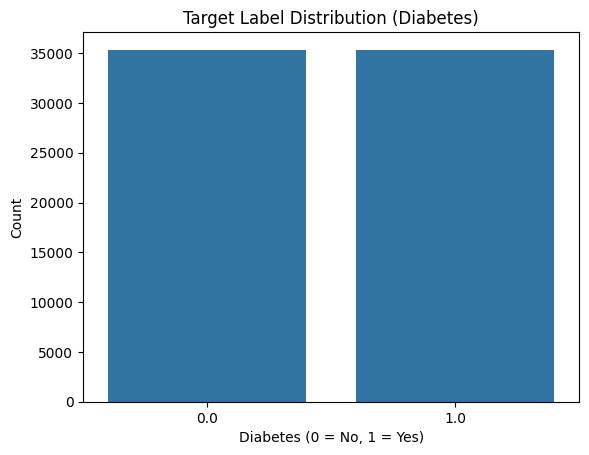

In [81]:

# Display dataset shape and first few rows
print("Dataset shape:", df_shuffled.shape)
print(df_shuffled.head())

# Check for null values
print("\nMissing values:")
print(df_shuffled.isnull().sum())

# Target column: Diabetes (0 or 1)
# Separate features and target
X = df_shuffled.drop(columns=['Diabetes'])
y = df_shuffled['Diabetes']

# Normalize numeric input features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Print resulting shapes
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Plot feature distribution examples
plt.figure(figsize=(12, 6))
sns.histplot(X['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

sns.countplot(x=y)
plt.title('Target Label Distribution (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


# Phase 2

Overfitting the data

In [82]:
# Resume or initialize overfitting results
results_path = os.path.join(checkpoint_dir, 'overfit_results.pkl')
if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        overfitting_results = pickle.load(f)
else:
    overfitting_results = []
done_configs = {cfg for cfg, *_ in overfitting_results}

In [83]:
# Store results for Phase 2
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value
    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor, 0) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True

In [84]:
def build_and_train_overfit_model(hidden_layers, neurons_per_layer, input_dim, epochs, batch_size):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    early_stop = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)
    history = model.fit(
        X_scaled, y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop]
    )
    final_acc = history.history['accuracy'][-1]
    return model, history, final_acc

In [ ]:
epoch_options      = [250]
batch_size_options = [256]
layer_sizes        = [5, 6, 7]
neuron_options     = [256, 512, 1024]

total_start = time.time()

for epochs in epoch_options:
    for batch_size in batch_size_options:
        for layers in layer_sizes:
            for neurons in neuron_options:
                cfg = f"{epochs}e_{batch_size}b_{layers}l_{neurons}n"
                if cfg in done_configs:
                    print(f"✔ Skipping {cfg}, already done.")
                    continue
                print(f"▶ Training model: {cfg}")
                start = time.time()
                model, history, final_acc = build_and_train_overfit_model(
                    hidden_layers=layers,
                    neurons_per_layer=neurons,
                    input_dim=X_scaled.shape[1],
                    epochs=epochs,
                    batch_size=batch_size
                )
                elapsed = time.time() - start
                print(f"Finished model: {cfg} in {elapsed:.2f}s with acc={final_acc:.4f}")
                # Record result
                overfitting_results.append((cfg, final_acc, elapsed))
                done_configs.add(cfg)
                # Persist results
                with open(results_path, 'wb') as f:
                    pickle.dump(overfitting_results, f)
                import pandas as pd
                df = pd.DataFrame(overfitting_results, columns=['config','accuracy','time_s'])
                df.to_csv(os.path.join(checkpoint_dir, 'overfit_results.csv'), index=False)


▶ Training model: 250e_256b_7l_4096n
Epoch 1/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.6854 - loss: 0.6153
Epoch 2/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7469 - loss: 0.5192
Epoch 3/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7505 - loss: 0.5078
Epoch 4/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7513 - loss: 0.5086
Epoch 5/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7517 - loss: 0.5044
Epoch 6/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.7527 - loss: 0.5057
Epoch 7/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7524 - loss: 0.5057
Epoch 8/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7515 - loss: 0.5083
Epoch 9/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7538 - loss: 0.5023
Epoch 10/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.7541 - loss: 0.5013
Epoch 11/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.75

In [37]:
total_elapsed = time.time() - total_start
print("\nOverfitting Results:")
for cfg, acc, t in overfitting_results:
    print(f"{cfg} => Training Accuracy: {acc:.4f}, Time: {t:.2f}s")
print(f"\nTotal training time for all models: {total_elapsed:.2f}s")



Overfitting Results:
1e_256b_1l_100n => Training Accuracy: 0.7171, Time: 6.07s
1e_256b_1l_10n => Training Accuracy: 0.6876, Time: 4.70s
250e_256b_5l_256n => Training Accuracy: 0.9154, Time: 279.39s
250e_256b_5l_512n => Training Accuracy: 0.9303, Time: 326.99s
250e_256b_5l_1024n => Training Accuracy: 0.9377, Time: 541.73s
250e_256b_6l_256n => Training Accuracy: 0.9237, Time: 314.27s
250e_256b_6l_512n => Training Accuracy: 0.9262, Time: 378.22s
250e_256b_6l_1024n => Training Accuracy: 0.9365, Time: 580.51s
250e_256b_7l_256n => Training Accuracy: 0.9151, Time: 336.88s
250e_256b_7l_512n => Training Accuracy: 0.9298, Time: 505.91s
250e_256b_7l_1024n => Training Accuracy: 0.9353, Time: 619.04s
250e_256b_7l_2048n => Training Accuracy: 0.9364, Time: 2127.32s
250e_256b_7l_4096n => Training Accuracy: 0.9345, Time: 8954.10s

Total training time for all models: 12212.40s


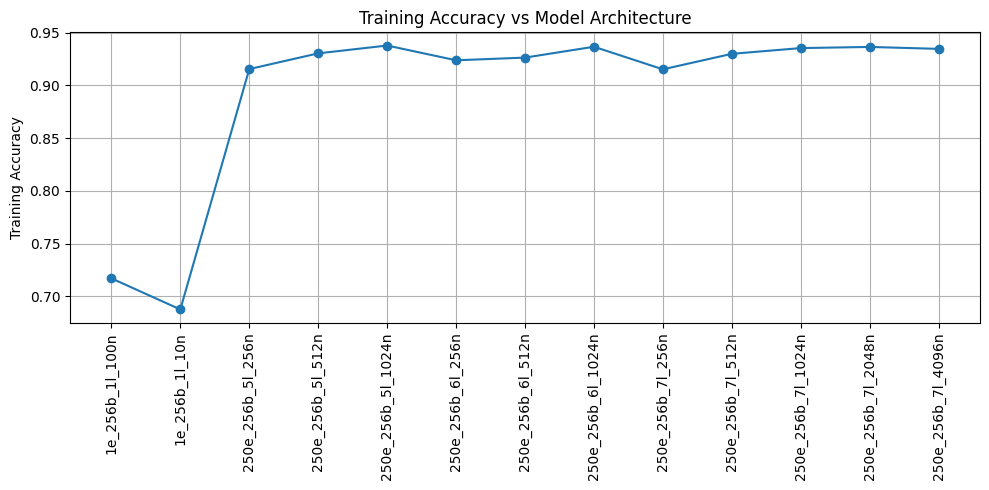

In [38]:
# Plot Accuracy vs Model Configuration
plt.figure(figsize=(10,5))
configs = [cfg for cfg, _, _ in overfitting_results]
accuracies = [acc for _, acc, _ in overfitting_results]
plt.plot(range(len(configs)), accuracies, marker='o')
plt.xticks(range(len(configs)), configs, rotation=90)
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Model Architecture")
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase 3: Model Selection and Evaluation

In [85]:
# Store evaluation results
evaluation_results = []
metrics_csv = os.path.join(eval_checkpoint_dir, 'phase3_metrics.csv')

In [86]:
# Define metric columns
df_columns = [
    'Model','Train_Acc','Train_Loss',
    'Val_Loss','Val_Acc',
    'Precision','Recall','F1_Score','Params','Time_s'
]
# Load existing metrics or initialize empty DataFrame
if os.path.exists(metrics_csv):
    metrics_df = pd.read_csv(metrics_csv)
else:
    metrics_df = pd.DataFrame(columns=df_columns)

#One-time ingestion of existing .keras checkpoints
if metrics_df.empty:
    def ingest_checkpoint(fname):
        model_name = fname.replace('_best.keras','')
        path = os.path.join(eval_checkpoint_dir, fname)
        print(f"Processing existing checkpoint: {model_name}")
        start = time.time()
        model = load_model(path)
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        preds = np.round(model.predict(X_val)).flatten()
        precision = precision_score(y_val, preds)
        recall = recall_score(y_val, preds)
        f1 = f1_score(y_val, preds)
        params = model.count_params()
        elapsed = time.time() - start
        metrics_df.loc[len(metrics_df)] = [
            model_name, train_acc, train_loss,
            val_loss, val_acc,
            precision, recall, f1,
            params, elapsed
        ]
    for fname in sorted(os.listdir(eval_checkpoint_dir)):
        if fname.endswith('_best.keras'):
            ingest_checkpoint(fname)
    metrics_df.to_csv(metrics_csv, index=False)
    print(f"Consolidated metrics saved to {metrics_csv}")

In [87]:
# Early stopping callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value
    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor, 0) >= self.value:
            print(f"Reached {self.value*100:.1f}% accuracy. Stopping.")
            self.model.stop_training = True

In [88]:
# Training & evaluation function with timing
def train_and_evaluate_model(full_name, layers, units, epochs=250, batch_size=64):
    model = Sequential([Input(shape=(X_train.shape[1],))])
    for _ in range(layers): model.add(Dense(units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

    ckpt_path = os.path.join(eval_checkpoint_dir, f"{full_name}_best.keras")
    checkpoint = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, mode='min')
    early_stop = EarlyStoppingByAccuracy()

    print(f"Training model: {full_name}")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=[checkpoint, early_stop], verbose=1
    )
    elapsed = time.time() - start
    print(f"Finished {full_name} in {elapsed:.1f}s")

    best = load_model(ckpt_path)
    train_loss, train_acc = best.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = best.evaluate(X_val, y_val, verbose=0)
    preds = np.round(best.predict(X_val)).flatten()
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    params = best.count_params()
    metrics_df.loc[len(metrics_df)] = [
        full_name, train_acc, train_loss,
        val_loss, val_acc,
        precision, recall, f1,
        params, elapsed
    ]
    metrics_df.to_csv(metrics_csv, index=False)


In [89]:
# 1) Random Baseline
if 'Random Baseline' not in metrics_df['Model'].values:
    random_preds = np.random.choice([0,1], size=y_val.shape)
    metrics_df.loc[len(metrics_df)] = [
        'Random Baseline',
        accuracy_score(y_train, np.random.choice([0,1], size=y_train.shape)),
        1.0,
        1.0, accuracy_score(y_val, random_preds),
        precision_score(y_val, random_preds),
        recall_score(y_val, random_preds),
        f1_score(y_val, random_preds),
        '-', 0.0
    ]
    metrics_df.to_csv(metrics_csv, index=False)

In [90]:
# 2) Logistic Regression
if 'Logistic Regression' not in metrics_df['Model'].values:
    train_and_evaluate_model('Logistic Regression', 0, 1)

In [91]:
# 3. Neural Network Architectures to Evaluate
architectures = {
}
for name, layers in architectures.items():
    if name not in metrics_df['Model'].values:
        train_and_evaluate_model(name, len(layers), layers[0])

In [92]:
# Identify Best Model
best_model = metrics_df.sort_values(by='Val_Acc', ascending=False).iloc[0]
print("\nBest Performing Model:")
print(best_model)


Best Performing Model:
Model         5-5-5-5-5-1
Train_Acc        0.752869
Train_Loss       0.502792
Val_Loss         0.510391
Val_Acc          0.750212
Precision        0.728494
Recall           0.797737
F1_Score         0.761545
Params                216
Time_s           7.857382
Name: 18, dtype: object


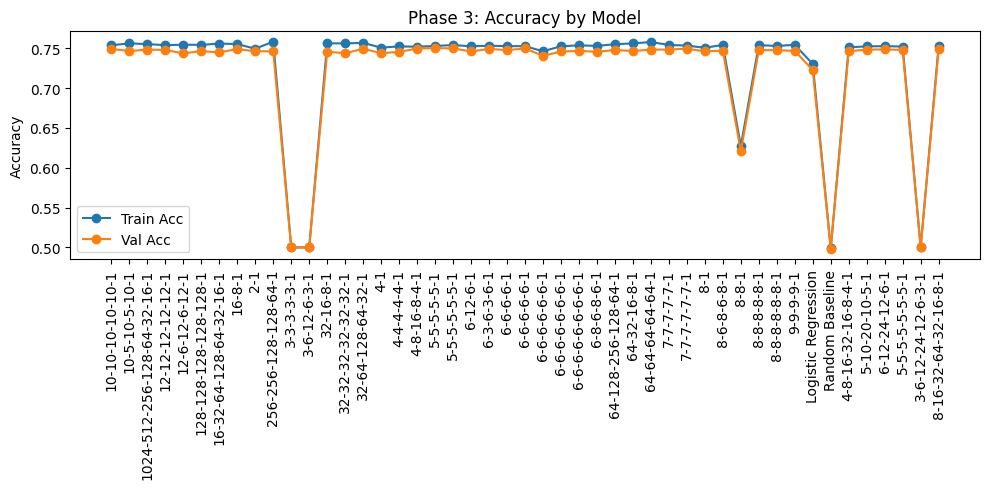

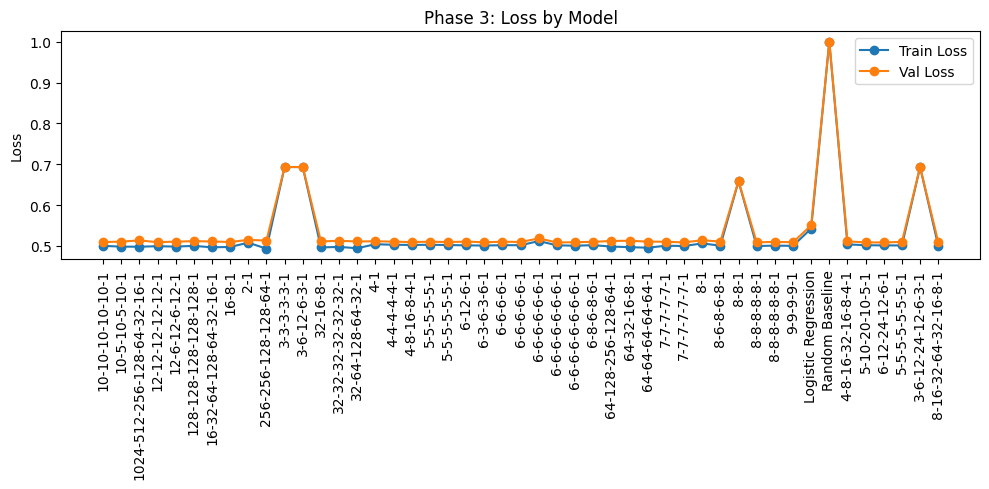

In [93]:
# Identify best model
metrics_df = pd.read_csv(metrics_csv)
best = metrics_df.sort_values('Val_Acc',ascending=False).iloc[0]

# Plot Accuracy across models from CSV
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Model'],metrics_df['Train_Acc'],marker='o',label='Train Acc')
plt.plot(metrics_df['Model'],metrics_df['Val_Acc'],marker='o',label='Val Acc')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Phase 3: Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss across models from CSV
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Model'],metrics_df['Train_Loss'],marker='o',label='Train Loss')
plt.plot(metrics_df['Model'],metrics_df['Val_Loss'],marker='o',label='Val Loss')
plt.xticks(rotation=90)
plt.ylabel('Loss')
plt.title('Phase 3: Loss by Model')
plt.legend()
plt.tight_layout()
plt.show()

# Phase 4


In [106]:
#Load Phase 3 metrics and select best architecture
metrics_csv = '/content/drive/MyDrive/colab_checkpoints/model_evaluation_data/phase3_metrics.csv'
metrics_df = pd.read_csv(metrics_csv)
best_row = metrics_df.sort_values('Val_Acc', ascending=False).iloc[0]
best_arch_name = best_row['Model']
best_units = [int(x) for x in best_arch_name.split('-')[:-1]]
print(f"Using best architecture: {best_arch_name} -> layers: {best_units}")

Using best architecture: 5-5-5-5-5-1 -> layers: [5, 5, 5, 5, 5]


In [107]:
# Early stopping callback at 99% training accuracy
def make_early_stop(threshold=0.99):
    class EarlyStoppingByAccuracy(Callback):
        def __init__(self):
            super().__init__()
            self.monitor = 'accuracy'
            self.value = threshold
        def on_epoch_end(self, epoch, logs=None):
            if logs.get(self.monitor, 0) >= self.value:
                print(f"Reached {self.value*100:.1f}% acc, stopping training.")
                self.model.stop_training = True
    return EarlyStoppingByAccuracy()

In [108]:
# Model builder using best_units
def make_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for units in best_units:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(1e-3),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [109]:
# Feature list (exclude target)
feature_names = [
    'Age','Sex','HighChol','CholCheck','BMI','Smoker',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth',
    'DiffWalk','Stroke','HighBP'
]

# Phase 4a: Single feature importance
single_feat_scores = []
for feat in feature_names:
    X_tr_f = X_train[[feat]].values
    X_va_f = X_val[[feat]].values
    model = make_model(input_dim=1)
    ckpt = ModelCheckpoint(
        os.path.join(checkpoint_dir, f'feat_{feat}.keras'),
        monitor='val_accuracy', save_best_only=True
    )
    hist = model.fit(
        X_tr_f, y_train,
        validation_data=(X_va_f, y_val),
        epochs=50, batch_size=256,
        callbacks=[make_early_stop(), ckpt],
        verbose=0
    )
    best_val = max(hist.history['val_accuracy'])
    single_feat_scores.append((feat, best_val))
    print(f"Feature {feat}: val_acc = {best_val:.4f}")

Feature Age: val_acc = 0.6119
Feature Sex: val_acc = 0.5253
Feature HighChol: val_acc = 0.6345
Feature CholCheck: val_acc = 0.5000
Feature BMI: val_acc = 0.6436
Feature Smoker: val_acc = 0.5421
Feature HeartDiseaseorAttack: val_acc = 0.5737
Feature PhysActivity: val_acc = 0.5761
Feature Fruits: val_acc = 0.5304
Feature Veggies: val_acc = 0.5310
Feature HvyAlcoholConsump: val_acc = 0.5000
Feature GenHlth: val_acc = 0.6895
Feature MentHlth: val_acc = 0.5327
Feature PhysHlth: val_acc = 0.5929
Feature DiffWalk: val_acc = 0.6158
Feature Stroke: val_acc = 0.5303
Feature HighBP: val_acc = 0.6803


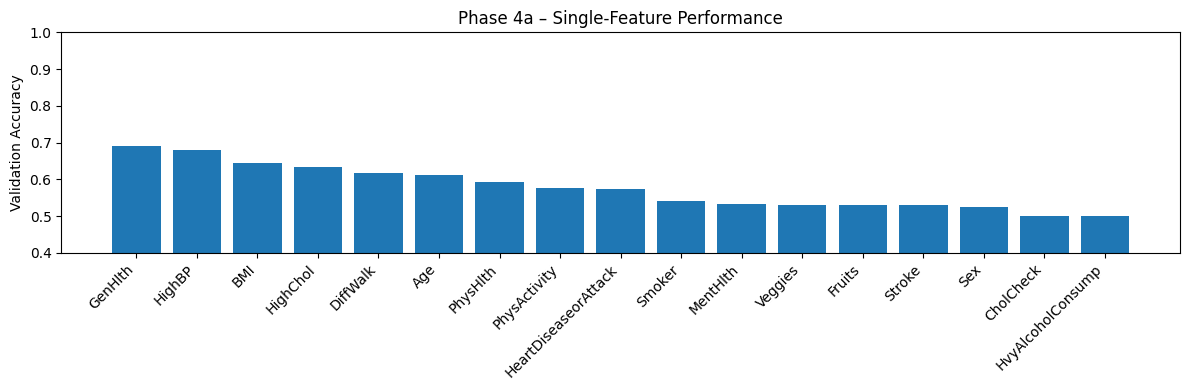

In [110]:
# Plot single feature importances
sorted_scores = sorted(single_feat_scores, key=lambda x: x[1], reverse=True)
names, scores = zip(*sorted_scores)
plt.figure(figsize=(12,4))
plt.bar(names, scores)
plt.ylim(0.40,1.00)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Validation Accuracy')
plt.title('Phase 4a – Single-Feature Performance')
plt.tight_layout()
plt.show()

In [111]:
#Phase 4b: iterative removal of least important
ranked_feats       = [f for f,_ in sorted_scores]
reduced_feat_scores = []
for k in range(len(ranked_feats), 0, -1):
    keep = ranked_feats[:k]
    X_tr_sub = X_train[keep].values
    X_va_sub = X_val[keep].values
    model = make_model(input_dim=len(keep))
    ckpt = ModelCheckpoint(
        os.path.join(checkpoint_dir, f'reduced_{k}.keras'),
        monitor='val_accuracy', save_best_only=True
    )
    hist = model.fit(
        X_tr_sub, y_train,
        validation_data=(X_va_sub, y_val),
        epochs=50, batch_size=256,
        callbacks=[make_early_stop(), ckpt],
        verbose=0
    )
    best_val = max(hist.history['val_accuracy'])
    reduced_feat_scores.append((keep, best_val))
    print(f"Kept {k} features: val_acc = {best_val:.4f}")

Kept 17 features: val_acc = 0.7494
Kept 16 features: val_acc = 0.7489
Kept 15 features: val_acc = 0.7460
Kept 14 features: val_acc = 0.7461
Kept 13 features: val_acc = 0.7471
Kept 12 features: val_acc = 0.7443
Kept 11 features: val_acc = 0.7464
Kept 10 features: val_acc = 0.7474
Kept 9 features: val_acc = 0.7465
Kept 8 features: val_acc = 0.7433
Kept 7 features: val_acc = 0.7470
Kept 6 features: val_acc = 0.7458
Kept 5 features: val_acc = 0.7325
Kept 4 features: val_acc = 0.7301
Kept 3 features: val_acc = 0.7245
Kept 2 features: val_acc = 0.7055
Kept 1 features: val_acc = 0.5000


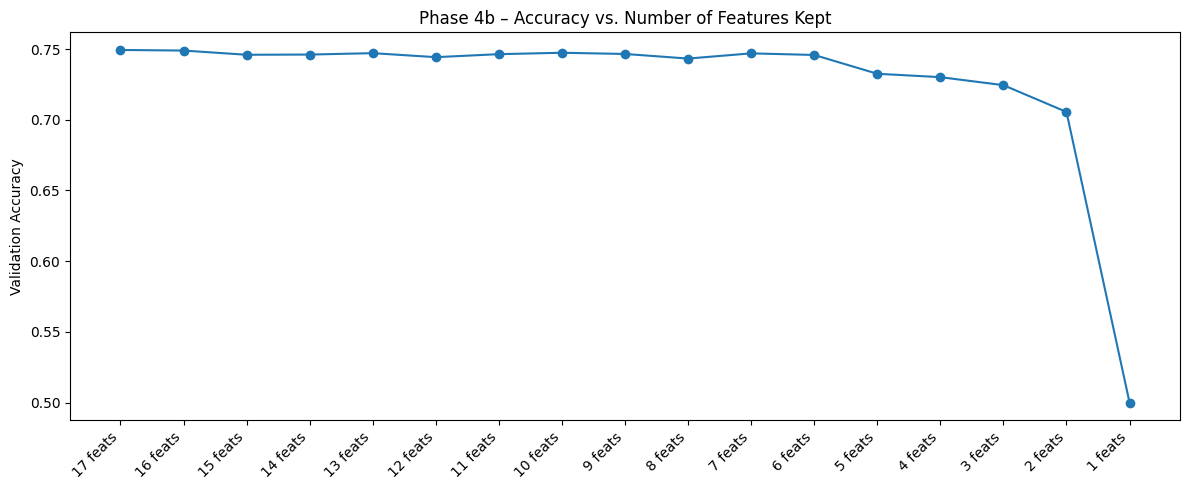

In [112]:
# Plot iterative-removal results
labels = [f"{len(keep)} feats" for keep,_ in reduced_feat_scores]
vals   = [v for _,v in reduced_feat_scores]
plt.figure(figsize=(12,5))
plt.plot(vals, marker='o')
plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
plt.ylabel('Validation Accuracy')
plt.title('Phase 4b – Accuracy vs. Number of Features Kept')
plt.tight_layout()
plt.show()

In [113]:
# Full-model baseline comparison
model_full = make_model(input_dim=len(feature_names))
ckpt_full = ModelCheckpoint(
    os.path.join(checkpoint_dir,'full_model.keras'),
    monitor='val_accuracy', save_best_only=True
)
hist_full = model_full.fit(
    X_train[feature_names].values, y_train,
    validation_data=(X_val[feature_names].values, y_val),
    epochs=50, batch_size=256,
    callbacks=[make_early_stop(), ckpt_full],
    verbose=0
)
full_val = max(hist_full.history['val_accuracy'])
print(f"Full-model val_acc = {full_val:.4f}")

Full-model val_acc = 0.7468


In [114]:
#Select overall best model (full or reduced)
candidates = [('full', full_val, os.path.join(checkpoint_dir,'full_model.keras'))]
candidates += [
    (f'reduced_{len(keep)}', val, os.path.join(checkpoint_dir,f'reduced_{len(keep)}.keras'))
    for keep,val in reduced_feat_scores
]
best_tag, best_val, best_path = max(candidates, key=lambda x: x[1])
best_model_final = load_model(best_path)
best_model_final.save(os.path.join(checkpoint_dir,'best_model_final.keras'))
print(f"Saved best_model_final ({best_tag}) val_acc = {best_val:.4f}")


Saved best_model_final (reduced_17) val_acc = 0.7494


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


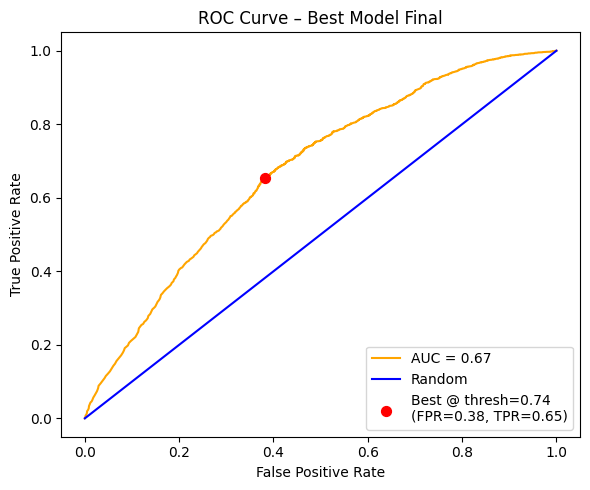

In [115]:
# ROC and AUC for best_model_final
y_scores = best_model_final.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# find optimal threshold by Youden's J statistic (tpr - fpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]
best_thresh = thresholds[best_idx]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='orange')
plt.plot([0,1], [0,1], linestyle='-', label='Random', color='blue')
# mark the best point
plt.scatter(best_fpr, best_tpr, color='red', s=50, zorder=5,
            label=f"Best @ thresh={best_thresh:.2f}\n(FPR={best_fpr:.2f}, TPR={best_tpr:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Best Model Final')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()